# Assignment-6

Please find 2 ML-based anomaly detection algorithms (other than Elliptic Envelope) and do the following:

    * Explain the theory (working logic) of these models.
    * Given a stock(s) of your choice, run these models, find the anomalies and compare the results.
    
**Note:** You do not need to apply hard math to explain everything behind these models.

#### Import Relevant Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
pd.set_option('use_inf_as_na', True)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

#### Read and tidy the dataset. The stock I will focus on is SentinelOne Inc (S).

In [2]:
#read in crash_data.csv
df = pd.read_csv('crash_data.csv')

In [3]:
df.head()

,Unnamed: 0,RET,date,TICKER,vwretx,BIDLO,ASKHI,PRC,VOL
0,27882462,0.041833,20100104,BAC,0.017045,15.12,15.750,15.69,180845100.0
1,27882463,0.032505,20100105,BAC,0.003362,15.70,16.210,16.20,209521200.0
2,27882464,0.011728,20100106,BAC,0.001769,16.03,16.540,16.39,205257900.0
3,27882465,0.032947,20100107,BAC,0.002821,16.51,17.185,16.93,320868400.0
4,27882466,-0.008860,20100108,BAC,0.004161,16.63,17.100,16.78,220104600.0


In [4]:
df['TICKER'].unique()

array(['BAC', 'GE', 'MSFT', 'PFE', 'T', 'CSCO', 'WFC', 'INTC', 'SIRI',
       'XOM', 'ORCL', 'KO', 'F', 'OUBS', 'UBS', 'JPM', 'S', 'VZ', 'AAPL',
       'WMT', 'MRK', 'CMCSA', 'JNJ', 'BBDO', 'PG', 'MOT', 'DWDP', 'TSU',
       'FB'], dtype=object)

In [5]:
df.date = pd.to_datetime(df.date, format='%Y%m%d')
df = df.set_index('date')

In [6]:
df = df.groupby('TICKER').resample('W').\
              agg({'RET':'mean', 'vwretx':'mean', 'VOL':'mean',
                   'BIDLO':'mean', 'ASKHI':'mean', 'PRC':'mean'})

In [7]:
df = df.reset_index()
df.dropna(inplace=True)

In [8]:
df

,TICKER,date,RET,vwretx,VOL,BIDLO,ASKHI,PRC
0,AAPL,2010-01-10,0.001235,0.005832,18980442.8,210.898000,213.864000,212.383998
1,AAPL,2010-01-17,-0.005719,-0.002080,19772230.6,206.772002,211.152002,208.767994
2,AAPL,2010-01-24,-0.009510,-0.009480,25930885.0,205.277505,212.888450,208.146752
3,AAPL,2010-01-31,-0.005426,-0.003738,52020594.0,198.250202,207.338002,201.650398
4,AAPL,2010-02-07,0.003722,-0.001463,26953208.4,192.304004,197.378002,195.466002
...,...,...,...,...,...,...,...,...
13398,XOM,2019-12-08,0.004058,0.000184,12371989.0,68.199000,68.946000,68.574000
13399,XOM,2019-12-15,-0.000734,0.001344,13958017.0,68.882000,70.160000,69.450000
13400,XOM,2019-12-22,0.002067,0.003199,18338291.4,69.384000,70.239340,69.776000
13401,XOM,2019-12-29,-0.000172,0.001220,9378504.5,69.832525,70.403075,70.082500


#### Histogram of SentinelOne Inc. appears to be normally distrubuted. 

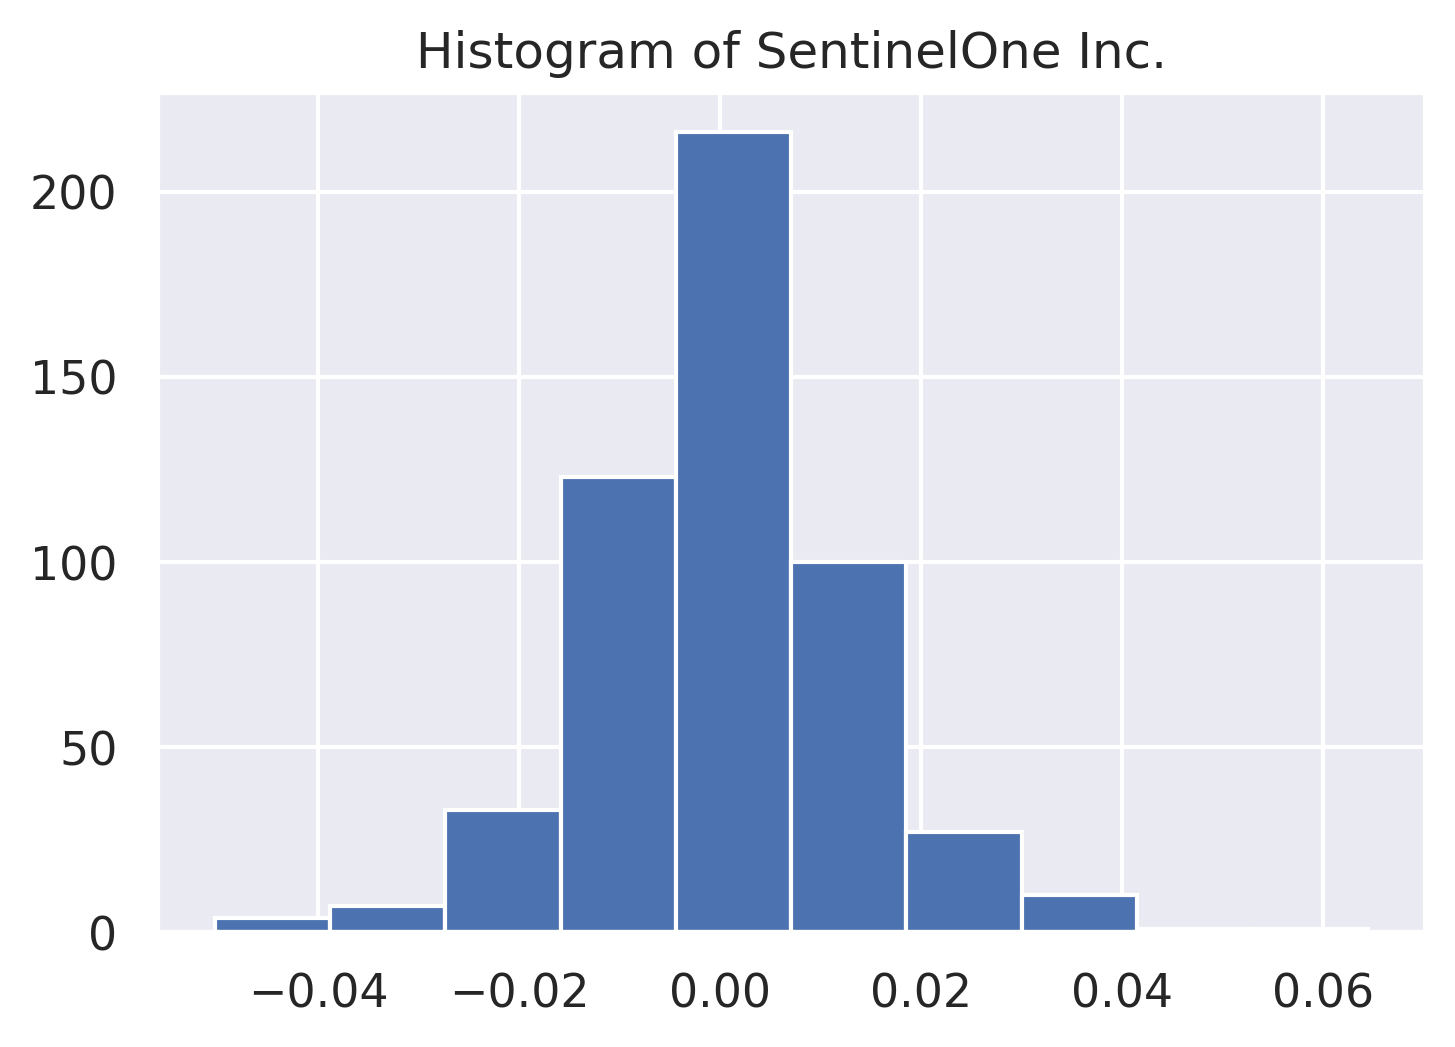

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(df[df.TICKER == 'S']['RET'])
plt.title('Histogram of SentinelOne Inc.')

plt.show()

#### Focus on SentinelOne Inc.

In [10]:
dfS = df.loc[df['TICKER'] == 'S']

dfS

,TICKER,date,RET,vwretx,VOL,BIDLO,ASKHI,PRC
8788,S,2010-01-10,0.016097,0.005832,54538640.00,3.898,4.10400,4.008
8789,S,2010-01-17,-0.005670,-0.002080,69706600.00,3.816,4.02600,3.892
8790,S,2010-01-24,-0.030835,-0.009480,71492450.00,3.445,3.63000,3.515
8791,S,2010-01-31,-0.005119,-0.003738,36848440.00,3.338,3.50200,3.400
8792,S,2010-02-07,0.010222,-0.001463,48219720.00,3.366,3.56602,3.490
...,...,...,...,...,...,...,...,...
9305,S,2019-12-08,-0.013289,0.000184,19095231.00,5.518,5.75200,5.604
9306,S,2019-12-15,-0.011810,0.001344,14021917.20,5.234,5.37200,5.278
9307,S,2019-12-22,0.006845,0.003199,14182153.80,5.198,5.30600,5.264
9308,S,2019-12-29,-0.008833,0.001220,7202446.25,5.200,5.32000,5.220


#### Isolation Forest
#### This unsupervised learning algorithm is commonly used to detect anamolies. It works by isolating outliers based on a decision tree. The output is a bunch of 1s (normal) and -1s (anamoly).

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [12]:
#Keep only date and return 

dfS = dfS[['date', 'RET']]
dfS

,date,RET
8788,2010-01-10,0.016097
8789,2010-01-17,-0.005670
8790,2010-01-24,-0.030835
8791,2010-01-31,-0.005119
8792,2010-02-07,0.010222
...,...,...
9305,2019-12-08,-0.013289
9306,2019-12-15,-0.011810
9307,2019-12-22,0.006845
9308,2019-12-29,-0.008833


In [13]:
#reset the index with the date

dfS.set_index('date', inplace=True)

In [14]:
dfS

,RET
date,
2010-01-10,0.016097
2010-01-17,-0.005670
2010-01-24,-0.030835
2010-01-31,-0.005119
2010-02-07,0.010222
...,...
2019-12-08,-0.013289
2019-12-15,-0.011810
2019-12-22,0.006845


In [15]:
scaler = StandardScaler()
dfS_scaled = scaler.fit_transform(dfS.values.reshape(-1,1))
dfS_scaled = pd.DataFrame(dfS_scaled)

In [16]:
dfS_scaled

,0
0,1.201773
1,-0.492723
2,-2.451724
3,-0.449814
4,0.744390
...,...
517,-1.085809
518,-0.970673
519,0.481548
520,-0.738915


In [17]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [18]:
contamination = np.arange(0.01, 0.05, 0.01)
outliers = []
for i in contamination:
    isolation_forest = IsolationForest(contamination=i)
    isolation_forest.fit(dfS_scaled)
    outliers.append(isolation_forest.predict(dfS_scaled))
    dfS['anomaly'] = isolation_forest.predict(dfS_scaled)

In [19]:
outliers

[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1, 

In [20]:
dfS['anomaly'].value_counts()

 1    501
-1     21
Name: anomaly, dtype: int64

#### Only 21 anamolies, out of 522 values. 

In [21]:
dfS[dfS['anomaly']==-1]

,RET,anomaly
date,,
2010-01-24,-0.030835,-1
2010-05-30,0.032837,-1
2010-10-31,-0.031207,-1
2011-07-31,-0.036847,-1
2011-08-07,-0.024012,-1
2011-08-14,-0.026856,-1
2011-10-09,-0.040249,-1
2012-06-10,0.035612,-1
2012-07-29,0.036917,-1


#### K Nearest Neighbors (KNN) 
#### This is a supervised machine learning algorithm. It will make predictions based on any (K) number of nearby data points. 

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#### Prior to scaling, the predictions were all zero because RET values were too close to zero. 
#### Multiplying the entire RET column by 1000 fixes this problem.  

In [23]:
dfS_KNN = df[['date', 'RET']]
dfS_KNN['RET'] = df['RET'].apply(lambda x: x*1000)

In [24]:
dfS_KNN

,date,RET
0,2010-01-10,1.2354
1,2010-01-17,-5.7192
2,2010-01-24,-9.5100
3,2010-01-31,-5.4256
4,2010-02-07,3.7224
...,...,...
13398,2019-12-08,4.0584
13399,2019-12-15,-0.7342
13400,2019-12-22,2.0668
13401,2019-12-29,-0.1720


In [25]:
X_train, X_test, y_train, y_test = train_test_split(dfS_KNN.drop(columns='RET'), dfS_KNN['RET'].astype('int'), test_size=0.2, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)

accuracy_score(y_test, pred)

0.11823946288698246

#### The accuracy score is very low even with a large K. KNN is not a good model for this data set. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b40b0712-78cc-43b6-a2a4-bcf9e16d6a1f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>